# About Dataset
Description
Prognostics and health management is an important topic in industry for predicting state of assets to avoid downtime and failures. This data set is the Kaggle version of the very well known public data set for asset degradation modeling from NASA. It includes Run-to-Failure simulated data from turbo fan jet engines.

Engine degradation simulation was carried out using C-MAPSS. Four different were sets simulated under different combinations of operational conditions and fault modes. Records several sensor channels to characterize fault evolution. The data set was provided by the Prognostics CoE at NASA Ames.

# Prediction Goal
In this dataset the goal is to predict the remaining useful life (RUL) of each engine in the test dataset. RUL is equivalent of number of flights remained for the engine after the last datapoint in the test dataset.

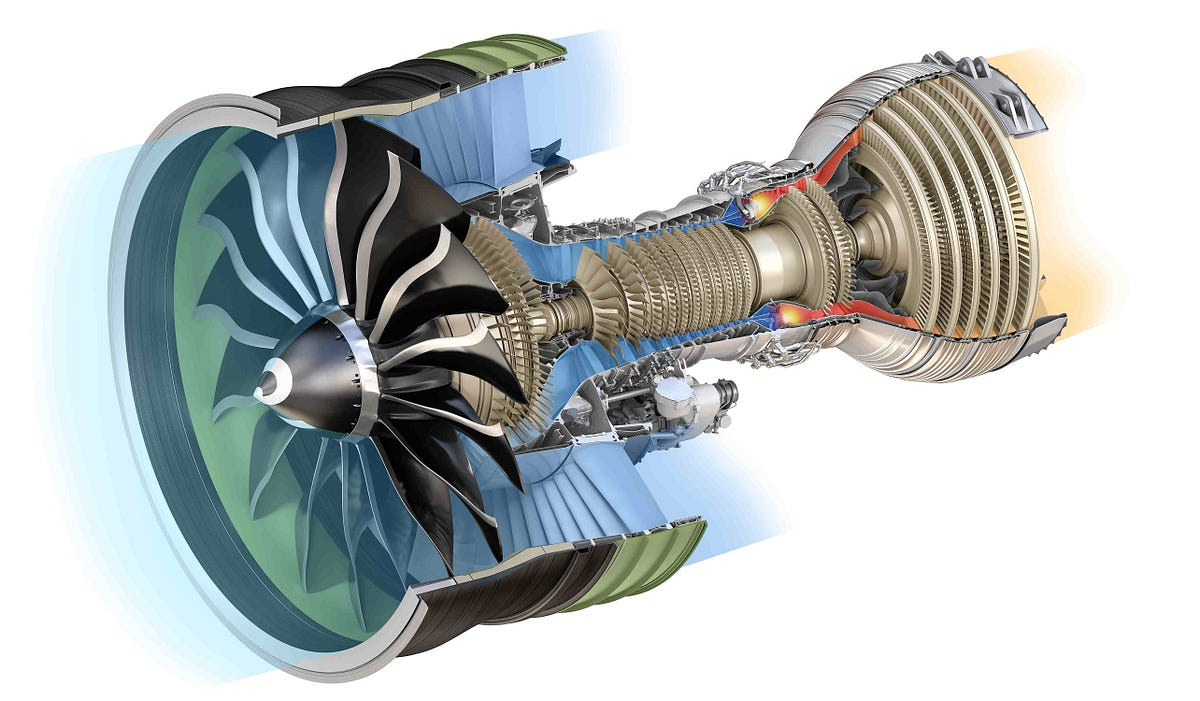

# Experimental Scenario
Data sets consists of multiple multivariate time series. Each data set is further divided into training and test subsets. Each time series is from a different engine i.e., the data can be considered to be from a fleet of engines of the same type. Each engine starts with different degrees of initial wear and manufacturing variation which is unknown to the user. This wear and variation is considered normal, i.e., it is not considered a fault condition. There are three operational settings that have a substantial effect on engine performance. These settings are also included in the data. The data is contaminated with sensor noise.

The engine is operating normally at the start of each time series, and develops a fault at some point during the series. In the training set, the fault grows in magnitude until system failure. In the test set, the time series ends some time prior to system failure. The objective of the competition is to predict the number of remaining operational cycles before failure in the test set, i.e., the number of operational cycles after the last cycle that the engine will continue to operate. Also provided a vector of true Remaining Useful Life (RUL) values for the test data.

# Importing dependencies

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns
import os

# Loading invidual text files into a single data frame

In [3]:
directory = '/content/drive/MyDrive/My_Projects/Nasa Turbo Fan  Project/archive/CMaps'

#Reading the tarining data
train_files = ['train_FD001.txt','train_FD002.txt','train_FD003.txt','train_FD004.txt']

#Defining column names
columns = [
    'unit_number', 'time_in_cycles', 'op_setting_1', 'op_setting_2', 'op_setting_3',
    'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6', 'sensor_7',
    'sensor_8', 'sensor_9', 'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14',
    'sensor_15', 'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20',
    'sensor_21'
]

#Loading and processing data
def load_data(file_name):
  df = pd.read_csv(os.path.join(directory,file_name),sep='\s+', header=None)
  df.columns = columns
  return df

#Loading the training data into a single data frame
train_df_list = [load_data(file) for file in train_files]
train_df = pd.concat(train_df_list, ignore_index=True)

train_df.head()

,unit_number,time_in_cycles,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [4]:
#Checking all the columns that are not displaying in the above data frame
train_df.iloc[:,9:17]

,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,sensor_11,sensor_12
0,14.62,21.61,554.36,2388.06,9046.19,1.30,47.47,521.66
1,14.62,21.61,553.75,2388.04,9044.07,1.30,47.49,522.28
2,14.62,21.61,554.26,2388.08,9052.94,1.30,47.27,522.42
3,14.62,21.61,554.45,2388.11,9049.48,1.30,47.13,522.86
4,14.62,21.61,554.00,2388.06,9055.15,1.30,47.28,522.19
...,...,...,...,...,...,...,...,...
160354,10.52,15.46,404.59,2319.66,8840.16,1.27,46.08,380.16
160355,14.62,21.57,567.59,2388.47,9117.12,1.31,48.04,535.02
160356,14.62,21.57,569.04,2388.51,9126.53,1.31,48.24,535.41
160357,5.48,7.96,199.93,2223.78,8403.64,1.05,42.53,187.92


# Exploratory Data Analysis

## Check Data Types and Missing Values:

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160359 entries, 0 to 160358
Data columns (total 26 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   unit_number     160359 non-null  int64  
 1   time_in_cycles  160359 non-null  int64  
 2   op_setting_1    160359 non-null  float64
 3   op_setting_2    160359 non-null  float64
 4   op_setting_3    160359 non-null  float64
 5   sensor_1        160359 non-null  float64
 6   sensor_2        160359 non-null  float64
 7   sensor_3        160359 non-null  float64
 8   sensor_4        160359 non-null  float64
 9   sensor_5        160359 non-null  float64
 10  sensor_6        160359 non-null  float64
 11  sensor_7        160359 non-null  float64
 12  sensor_8        160359 non-null  float64
 13  sensor_9        160359 non-null  float64
 14  sensor_10       160359 non-null  float64
 15  sensor_11       160359 non-null  float64
 16  sensor_12       160359 non-null  float64
 17  sensor_13 

## Basic Statistics:

In [6]:
train_df.describe()

,unit_number,time_in_cycles,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
count,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,...,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000
mean,105.553758,123.331338,17.211973,0.410004,95.724344,485.840890,597.361022,1467.035653,1260.956434,9.894999,...,338.789821,2349.645243,8088.950972,9.054747,0.025185,360.698801,2273.754039,98.389146,25.942709,15.565700
std,72.867325,83.538146,16.527988,0.367938,12.359044,30.420388,42.478516,118.175261,136.300073,4.265554,...,164.193480,111.167242,80.623257,0.751581,0.004997,31.021430,142.513114,4.656270,11.691422,7.015067
min,1.000000,1.000000,-0.008700,-0.000600,60.000000,445.000000,535.480000,1242.670000,1023.770000,3.910000,...,128.310000,2027.570000,7845.780000,8.156300,0.020000,302.000000,1915.000000,84.930000,10.160000,6.010500
25%,44.000000,57.000000,0.001300,0.000200,100.000000,449.440000,549.960000,1357.360000,1126.830000,5.480000,...,164.790000,2387.970000,8070.530000,8.439250,0.020000,332.000000,2212.000000,100.000000,14.330000,8.601300
50%,89.000000,114.000000,19.998100,0.620000,100.000000,489.050000,605.930000,1492.810000,1271.740000,9.350000,...,321.690000,2388.070000,8118.590000,9.030100,0.030000,367.000000,2319.000000,100.000000,24.920000,14.953500
75%,164.000000,173.000000,35.001500,0.840000,100.000000,518.670000,642.340000,1586.590000,1402.200000,14.620000,...,521.340000,2388.160000,8139.410000,9.344200,0.030000,392.000000,2388.000000,100.000000,38.820000,23.294600
max,260.000000,543.000000,42.008000,0.842000,100.000000,518.670000,645.110000,1616.910000,1441.490000,14.620000,...,537.490000,2390.490000,8293.720000,11.066900,0.030000,400.000000,2388.000000,100.000000,39.890000,23.950500


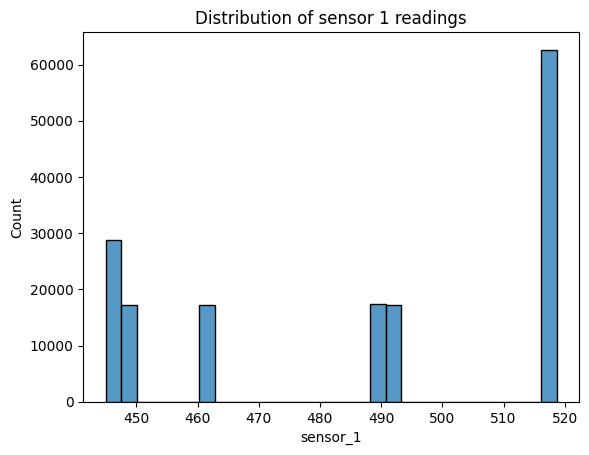

In [7]:
sns.histplot(train_df['sensor_1'])
plt.title('Distribution of sensor 1 readings')
plt.show()

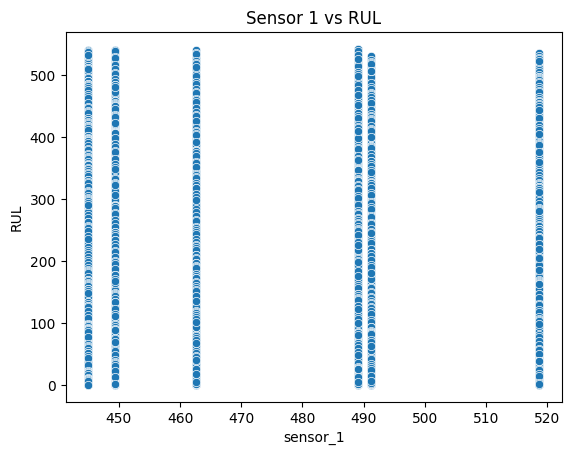

In [8]:
#
rul = train_df.groupby('unit_number')['time_in_cycles'].max().reset_index()
rul.columns = ['unit_number', 'max_time_in_cycles']
train_df = train_df.merge(rul, on=['unit_number'], how='left')
train_df['RUL'] = train_df['max_time_in_cycles'] - train_df['time_in_cycles']
train_df.drop('max_time_in_cycles', axis=1, inplace=True)

# Scatter plot of sensor 1 vs RUL
sns.scatterplot(x='sensor_1', y='RUL', data=train_df)
plt.title('Sensor 1 vs RUL')
plt.show()

# Data Cleaning, Preprocessing, and Feature Engineering

## Handling missing values

In [9]:
train_df.isnull().sum()

unit_number       0
time_in_cycles    0
op_setting_1      0
op_setting_2      0
op_setting_3      0
sensor_1          0
sensor_2          0
sensor_3          0
sensor_4          0
sensor_5          0
sensor_6          0
sensor_7          0
sensor_8          0
sensor_9          0
sensor_10         0
sensor_11         0
sensor_12         0
sensor_13         0
sensor_14         0
sensor_15         0
sensor_16         0
sensor_17         0
sensor_18         0
sensor_19         0
sensor_20         0
sensor_21         0
RUL               0
dtype: int64

## Normalize/Standardize Sensor Data

## Normalizing or standardize the sensor data to ensure all features contribute equally to the model

In [10]:
from sklearn.preprocessing import StandardScaler

#selecting sensor columns
sensor_columns = [f'sensor_{i}'for i in range(1,22) ]
scalar = StandardScaler()
train_df[sensor_columns] = scalar.fit_transform(train_df[sensor_columns])

# Feature Engineering
## Creating additional features that might help the model based on rolling statistics

In [11]:
for sensor in sensor_columns:
    train_df[f'{sensor}_rolling_mean'] = train_df.groupby('unit_number')[sensor].rolling(window=5).mean().reset_index(level=0, drop=True).fillna(method='bfill')

# Prepare the Data for Modeling

In [12]:

# Define features and target variable
X = train_df.drop(['unit_number', 'time_in_cycles', 'RUL'], axis=1)
y = train_df['RUL']

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=train_df['unit_number'])
print (X_train)
print (y_train)

        op_setting_1  op_setting_2  op_setting_3  sensor_1  sensor_2  \
68408        10.0029        0.2500         100.0  0.105492  0.170651   
148848       10.0063        0.2500         100.0  0.105492  0.166884   
156642       35.0037        0.8402         100.0 -1.196599 -0.974873   
110105       25.0047        0.6200          60.0 -0.765965 -1.425220   
151642       19.9991        0.7000         100.0  0.175840  0.229740   
...              ...           ...           ...       ...       ...   
13007        -0.0024       -0.0001         100.0  1.079185  1.071580   
42886        20.0028        0.7000         100.0  0.175840  0.244806   
17759        -0.0006        0.0000         100.0  1.079185  1.074169   
16329        -0.0030        0.0002         100.0  1.079185  1.070874   
7437         -0.0004        0.0001         100.0  1.079185  1.059574   

        sensor_3  sensor_4  sensor_5  sensor_6  sensor_7  ...  \
68408   0.333949  0.343754  0.146523  0.165283  0.200536  ...   
14884

# Model building and evaluation
We'll start by trying a few different regression models to predict the Remaining Useful Life (RUL):

Linear Regression,
Random Forest Regressor,
Gradient Boosting Regressor

# Training the models

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Initialize the models
linear_model = LinearRegression()
rf_model = RandomForestRegressor(random_state=42)
gb_model = GradientBoostingRegressor(random_state=42)

# Train the models
linear_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
gb_model.fit(X_train, y_train)


GradientBoostingRegressor(random_state=42)

# Evaluate the Models

In [14]:
# Defining a function to evaluate models
def evaluate_model(model, X_val, y_val):
    predictions = model.predict(X_val)
    mae = mean_absolute_error(y_val, predictions)
    rmse = np.sqrt(mean_squared_error(y_val, predictions))
    return mae, rmse

# Evaluate the models
linear_mae, linear_rmse = evaluate_model(linear_model, X_val, y_val)
rf_mae, rf_rmse = evaluate_model(rf_model, X_val, y_val)
gb_mae, gb_rmse = evaluate_model(gb_model, X_val, y_val)

print(f"Linear Regression - MAE: {linear_mae}, RMSE: {linear_rmse}")
print(f"Random Forest - MAE: {rf_mae}, RMSE: {rf_rmse}")
print(f"Gradient Boosting - MAE: {gb_mae}, RMSE: {gb_rmse}")

Linear Regression - MAE: 59.07693987884737, RMSE: 75.1324502597411
Random Forest - MAE: 54.30610875530058, RMSE: 70.16138296934336
Gradient Boosting - MAE: 57.177243470646246, RMSE: 73.65807904132173


# Model Selection

In [15]:
from sklearn.model_selection import train_test_split

# Use 10% of the training data for hyperparameter tuning
X_train_small, _, y_train_small, _ = train_test_split(X_train, y_train, train_size=0.1, random_state=42)

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import joblib

# Define a reduced parameter distribution
param_dist = {
    'n_estimators': randint(50, 150),
    'max_depth': randint(10, 20),
    'min_samples_split': randint(2, 5),
    'min_samples_leaf': randint(1, 2),
    'bootstrap': [True, False]
}

# Initialize RandomizedSearchCV with fewer iterations
random_search_rf = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=10,  # Reduced number of iterations
    cv=3,  # Reduced number of cross-validation folds
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=42
)

# Fit RandomizedSearchCV to the smaller training data
random_search_rf.fit(X_train_small, y_train_small)

# Get the best parameters and best score
best_params_rf = random_search_rf.best_params_
best_score_rf = -random_search_rf.best_score_

print(f"Best parameters: {best_params_rf}")
print(f"Best MAE score: {best_score_rf}")

# Save the best model
joblib.dump(random_search_rf.best_estimator_, 'tuned_random_forest_model.pkl')


Best parameters: {'bootstrap': True, 'max_depth': 17, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 149}
Best MAE score: 57.506449139213835


['tuned_random_forest_model.pkl']

In [16]:
best_rf_model = joblib.load('tuned_random_forest_model.pkl')

best_rf_mae, best_rf_rmse = evaluate_model(best_rf_model, X_val, y_val)
print(f"Tuned Random Forest - MAE: {best_rf_mae}, RMSE: {best_rf_rmse}")


Tuned Random Forest - MAE: 56.735508391221714, RMSE: 73.00691326620256


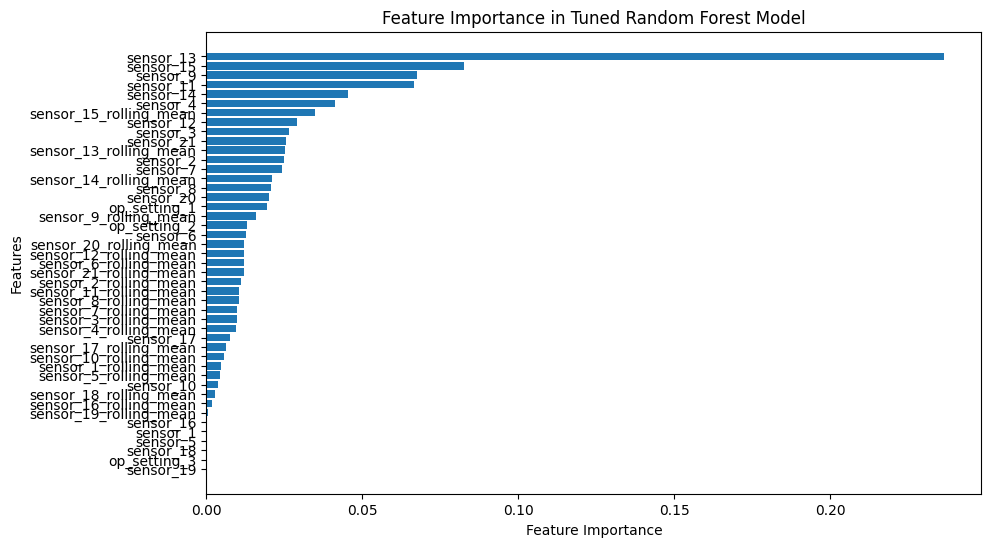

In [17]:
import matplotlib.pyplot as plt

importances = best_rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance in Tuned Random Forest Model')
plt.gca().invert_yaxis()
plt.show()
